In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.fftpack import * 

1D-DFT 前处理部分(运行过后可以跳过)

计算的ke的垂直积分

对结果进行了备份，完善在 pre_process.ipynb 中，这里暂时不删除

In [2]:
dir_in = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi/"
ds_vr_ke    = xr.open_mfdataset(dir_in + "*_RCM_ke_daily_vi.nc") # 自动合并 Time 坐标
# ----- select data range -----
lat_sel     = (ds_vr_ke.latitude >= 10) & (ds_vr_ke.latitude <= 60)
lon_sel     = (ds_vr_ke.longitude >= 70) & (ds_vr_ke.longitude <= 140)
plevels_sel = (ds_vr_ke.plevels >= 100) & (ds_vr_ke.plevels <= 200)
time_sel    = (ds_vr_ke.Time.dt.year >= 1998)
sel_dict    = {'longitude':lon_sel, "latitude":lat_sel, "plevels":plevels_sel, "Time":time_sel}
# ds_vr_ke[lon,lat,plevels,Time]
# ds_vr_le[]

In [3]:
# 进行垂直积分
vr_ke_sel = ds_vr_ke.isel(sel_dict)
sel_plevels_val = vr_ke_sel.plevels.values
vr_ke_sum = np.trapz(vr_ke_sel['ke'].values, sel_plevels_val, axis = 3) / (400. - 100.)
# 154 x 160 x 279 3d np array [time,lat,lon]

/m2data2/yycheng/anaconda3/envs/pync0326/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/m2data2/yycheng/anaconda3/envs/pync0326/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self

In [45]:
# 将numpy的nan处理为单独的数 -1e30
# np.isnan(vr_ke_sum).any() # 显然是有NAN的
# 将RCM的边缘NAN和本身插值造成的NAN一并处理掉了
rcm_ke_sum_rmnan = np.where(vr_ke_sum>1e10, -1e30, vr_ke_sum)

In [62]:
# 创建临时输出，方便后面再进行计算
dir_out = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi/"
# list(vr_ke_sel.coords)
coords_lon  = vr_ke_sel.longitude
coords_lat  = vr_ke_sel.latitude
coords_Time = vr_ke_sel.Time
# xr.DataArray(vr_ke_sum,dims = ['longitude', 'latitude', 'Time'])
temp_write = xr.DataArray(rcm_ke_sum_rmnan, name = "vertical integration Ke", coords = [coords_Time, coords_lat ,coords_lon],attrs={"caculation":"100-400hPa Ke trapz integration ( / 300hPa)"})
# temp_write.values = vr_ke_sum # 直接向values中写入
encoding_dict = {"vertical integration Ke":{"_FillValue":-1e30}}
temp_write.to_netcdf(dir_out + "ke_all_400-100_hPa_vi.nc",'w',\
    encoding = encoding_dict) # 此处进行NAN的处理：修改encoding方法

前处理完毕，下面进行计算，如果有过前处理，那么从这里开始运行

In [59]:
# 从临时输出读入，方便后面再进行计算
# model_type="VR"
model_type="RCM"
dir_out = "/raid52/yycheng/MPAS/"+model_type+"_postprocess/"+model_type+"_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum = ds_ke_sum['vertical integration Ke']

In [60]:
# 通过外插，去除掉边界上因RCM范围选取问题产生的nan的点
ke_rmnan = ke_sum.interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

In [61]:
# 选取数据范围 排除边界影响
sel_dict = {}
month_sel = ke_rmnan.Time.dt.month.isin([6,7,8])
sel_dict['Time'] = month_sel
lat = ke_rmnan.latitude
lon = ke_rmnan.longitude
sel_dict['latitude'] = lat[(lat>=30) & (lat<=50)]
# sel_dict['longitude'] = lon[(lon>=90) & (lon<=135)]
ke_selmon = ke_rmnan.loc[sel_dict]

下面有三种计算方法

- detrend 先平均，后计算谱系数

- 先计算谱系数，再在经度上平均，使用窗口

- 先计算平均，再计算谱系数，同样使用窗口

挑选一个进行运行：
最后多个时次上的DFT结果保存到ke_dft_time 平均之后的DFT序列保存到 ke_dft_mean

In [66]:
# 先计算经向上的平均，再计算谱系数（纬向上），再在时间上进行平均
# 使用detrend
from scipy import signal
N = ke_selmon.shape[2]
ke_detrend_lon = signal.detrend(ke_selmon.mean(axis=1),axis = 1)
ke_dft_time = fft(ke_detrend_lon)
ke_dft_mean = ke_dft_time.mean(axis=0)


In [44]:
# 先计算谱系数，再进行平均
# 使用窗口
from scipy.signal import get_window
from scipy import signal

N = ke_selmon.shape[2]
w = get_window('cosine', N)
# w = get_window('hanning', N)
# w = signal.windows.kaiser(N, beta=6, sym=False)
# 1D DCT on longitude
ke_dft = fft(ke_selmon.values*w)
# average on latitude
ke_dft_time = np.nanmean(ke_dft, axis = 1)
# time ave
ke_dft_mean = np.nanmean(ke_dft[:,:,:], axis = (0,1))

In [62]:
# 先进行平均，再计算谱系数
from scipy.signal import get_window
N = ke_selmon.shape[2]
w = get_window('cosine', N)
# w = get_window('hanning', N)

# average on longitude
vr_ke_dft = fft(ke_selmon.mean(axis=1).values*w)
# average on latitude
vr_ke_dft_time = vr_ke_dft
# time ave
vr_ke_dft_mean = np.nanmean(vr_ke_dft[:,:], axis = 0)

In [67]:
# 计算绘图所使用的频率等

# dft_var = vr_ke_dft_mean.size
# Number of samplepoints
N = ke_dft_mean.size # 280
# sample spacing
T = 1. / N
# xf freq
xf = fftfreq(N, T)[:N//2]         # 波数 （domain内）
domain_lon_range = 7061*1e3 # m 
xf_length = domain_lon_range / xf # 波长
xk = 1. / xf_length               # 波数 m^-1

<ipython-input-67-6150fa06ac35>:11: RuntimeWarning: divide by zero encountered in true_divide
  xf_length = domain_lon_range / xf # 波长


<ipython-input-68-5b4c5fc7c72c>:9: RuntimeWarning: divide by zero encountered in power
  yref_synop = (xaxis*1e6) ** (-3.) #* 10 ** (-19)
<ipython-input-68-5b4c5fc7c72c>:10: RuntimeWarning: divide by zero encountered in power
  yref_meso  = (xaxis*1e6) ** (-5./3) #* 10 ** (-11)
<ipython-input-68-5b4c5fc7c72c>:17: RuntimeWarning: divide by zero encountered in power
  yref_synop = (xaxis*1e6) ** (-3.) #* 10 ** (-19)
<ipython-input-68-5b4c5fc7c72c>:18: RuntimeWarning: divide by zero encountered in power
  yref_meso  = (xaxis*1e6) ** (-5./3) #* 10 ** (-11)


Text(0.5, 0.98, '400-100hPa total Ke 1D-DFT spectra & windows')

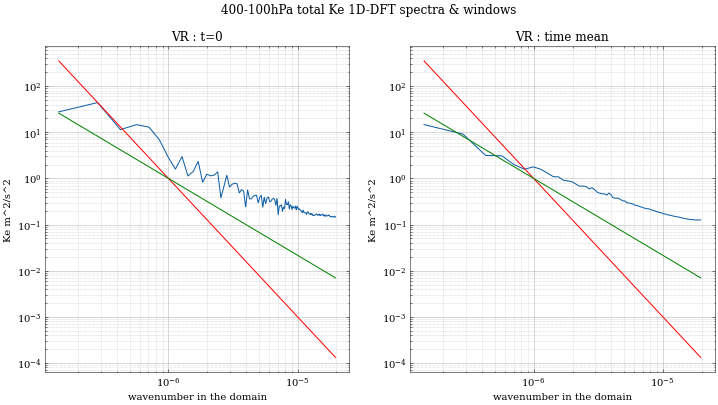

In [68]:
fig, axs = plt.subplots(1,2,figsize=(12, 6))

plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展
xaxis = xk # 选取 m^-1 的波数作为x轴
# np.abs 计算谱系数的模， 做振幅谱
# axs[0].plot(xaxis, np.abs(ke_dft_time[0, 0:N//2]))
axs[0].plot(xaxis[1:], 2./N * np.abs(ke_dft_time[0, 1:N//2])) # 振幅谱的系数该如何取？黄嘉佑书 Page433
# add reference line 
yref_synop = (xaxis*1e6) ** (-3.) #* 10 ** (-19)
yref_meso  = (xaxis*1e6) ** (-5./3) #* 10 ** (-11)
axs[0].plot(xaxis, yref_synop,color='r')
axs[0].plot(xaxis, yref_meso,color='g')

# axs[1].plot(xaxis, np.abs(ke_dft_mean[0:N//2]) )
axs[1].plot(xaxis[1:], 2./N * np.abs(ke_dft_mean[1:N//2]))
# add reference line
yref_synop = (xaxis*1e6) ** (-3.) #* 10 ** (-19)
yref_meso  = (xaxis*1e6) ** (-5./3) #* 10 ** (-11)
axs[1].plot(xaxis, yref_synop,color='r')
axs[1].plot(xaxis, yref_meso,color='g')

def upper_xaxis(x):
    domain_lon_range = 7061. # km
    return domain_lon_range / x

def upper_xaxis_inv(x):
    domain_lon_range = 7061. # km
    return (1. / x )/ domain_lon_range 

for axs_ind in axs:
    axs_ind.set_yscale('log')
    axs_ind.set_xscale('log')
    # axs_ind.secondary_xaxis('top', functions = (upper_xaxis, upper_xaxis_inv) )

    axs_ind.xaxis.grid(True, which="minor", linestyle = ":")
    axs_ind.xaxis.grid(True, which="major", linestyle = "-")
    axs_ind.yaxis.grid(True, which="minor", linestyle = ":")
    axs_ind.yaxis.grid(True, which="major", linestyle = "-")

    axs_ind.set_xlabel('wavenumber in the domain')
    axs_ind.set_ylabel('Ke m^2/s^2')
axs[0].set_title('VR : t=0')
axs[1].set_title('VR : time mean')
# axs[0].legend()
fig.suptitle("400-100hPa total Ke 1D-DFT spectra & windows")
